In [15]:
import gymnasium as gym
import numpy as np
from stable_baselines3.common.env_util import make_vec_env as make_vec_env_sb3
from copy import deepcopy
import torch
from torch.distributions import Normal,MultivariateNormal
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.utils.data import Dataset, DataLoader
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv
import imageio
import pandas as pd
from tqdm import tqdm
from PIL import Image
from stable_baselines3.dqn.policies import MlpPolicy
import matplotlib.pyplot as plt
import os

In [16]:
import gc
gc.collect()

2397

In [17]:
!nvidia-smi
# clean up memory forcefully
torch.cuda.empty_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device



Sat Apr 20 22:35:31 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 545.23.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1080 Ti     On  | 00000000:01:00.0 Off |                  N/A |
|  5%   49C    P2              57W / 250W |   1616MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

device(type='cuda')

In [18]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
class CustomDataset(Dataset):
    def __init__(self, observations, actions):
        self.observations = torch.tensor(observations, dtype=torch.float32,device=device)
        self.actions = torch.tensor(actions, dtype=torch.float32,device=device)

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx):
        observation = self.observations[idx]
        action = self.actions[idx]
        return observation, action

class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim,init_w=3e-3,log_std_min=-20,log_std_max=2):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)


        self.fc2 = nn.Linear(32, 32)
        self.log_std = nn.Linear(32, output_dim)
        self.mu=nn.Linear(32,output_dim)
        self.log_std_min=log_std_min
        self.log_std_max=log_std_max
        torch.nn.init.kaiming_normal_(self.fc1.weight)
        torch.nn.init.kaiming_normal_(self.fc2.weight)
        self.mu.weight.data.uniform_(-init_w,init_w)
        self.mu.bias.data.uniform_(-init_w,init_w)
        self.log_std.weight.data.uniform_(-init_w,init_w)
        self.log_std.bias.data.uniform_(-init_w,init_w)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mu = self.mu(x) # Only apply if action bounds are [-1, 1]
        log_std = self.log_std(x)  # Ensure std is positive
        log_std=torch.clamp(log_std,self.log_std_min,self.log_std_max)

        return mu, log_std


Using device: cuda


In [19]:
from imitation.util.util import make_vec_env

observations= np.load("../dataset/obs.npy", allow_pickle=True)
actions = np.load("../dataset/actions.npy", allow_pickle=True)
observations=observations.squeeze()
actions=actions.squeeze()
env=gym.make("Walker2d-v3",exclude_current_positions_from_observation=False,render_mode="rgb_array")


# test policy
# done=False
# reward_sum = 0
# frames = []
# while not done:
#     action, _states = model.predict(obs, deterministic=True)
#     obs, reward,truncate,done, info = env.step(action)
#     reward_sum += reward
#     frames.append(env.render())
    
# print(reward_sum)
# imageio.mimsave(os.path.join(os.path.dirname(__file__),"walker2d.gif"), frames)
    

/mnt/nfs/work/c98181/miniconda3/envs/copy/lib/python3.9/site-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment Walker2d-v3 is out of date. You should consider upgrading to version `v4`.
  logger.deprecation(
/mnt/nfs/work/c98181/miniconda3/envs/copy/lib/python3.9/site-packages/gymnasium/envs/mujoco/mujoco_env.py:211: DeprecationWarning: WARN: This version of the mujoco environments depends on the mujoco-py bindings, which are no longer maintained and may stop working. Please upgrade to the v4 versions of the environments (which depend on the mujoco python bindings instead), unless you are trying to precisely replicate previous works).
  logger.deprecation(


In [20]:
class mydataset(Dataset):
    def __init__(self, observations, actions):
        self.observations = torch.tensor(observations, dtype=torch.float32).to(device)
        self.actions = torch.tensor(actions, dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx):
        observation = self.observations[idx]
        action = self.actions[idx]
        return observation, action

In [21]:
policy_network = PolicyNetwork(18,6).to(device)
prev = PolicyNetwork(18,6).to(device)
prev.load_state_dict(policy_network.state_dict())
prev.eval()

optimizer = torch.optim.Adam(policy_network.parameters(), lr=1e-3,weight_decay=1e-4)

# Training loop
num_epochs = 20
batch_size = 32

dataset = mydataset(observations=observations, actions=actions)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

loss_graph=[]
greedy_rewards=[]
sample_rewards=[]
margin_graph=[]
positive_reward_graph=[]
negative_reward_graph=[]
log_interval = len(observations)//1
num_test = 1
prev_load_freq = 1000
now_log=0
now_pos=0
greedy_score=0
sample_score=0
for epoch in range(num_epochs):
    policy_network.train()

    # Compute the log probabilities of the actions
    pbar=tqdm(dataloader,position=0,leave=True)
    now_log=0

    for step, (obs_batch,act_batch) in enumerate(pbar):
        # obs_batch = torch.tensor(np.array(obs_batch), dtype=torch.float32).to(device)
        # act_batch = torch.tensor(np.array(act_batch), dtype=torch.float32).to(device)

        now_log+=obs_batch.shape[0]
        now_pos+=obs_batch.shape[0]
        
        mu, log_std = policy_network(obs_batch)
        std=log_std.exp()
        dist = Normal(mu, std)
        z_model=dist.rsample()
        model_action=torch.tanh(z_model)
        z_expert=torch.atanh(torch.clamp(act_batch, -0.999, 0.999))
        epsilon=1e-6


        policy_rejected_logps =dist.log_prob(z_model)-torch.log(1-model_action.pow(2)+epsilon)
        policy_chosen_logps = dist.log_prob(z_expert)-torch.log(1-act_batch.pow(2)+epsilon)

        with torch.no_grad():
          prev_mu, prev_log_std = prev(obs_batch)
          prev_std=prev_log_std.exp()
          prev_dist = Normal(prev_mu, prev_std)

          reference_rejected_logps =prev_dist.log_prob(z_model)-torch.log(1-model_action.pow(2)+epsilon)
          reference_chosen_logps = prev_dist.log_prob(z_expert)-torch.log(1-act_batch.pow(2)+epsilon)

        pi_logratios = policy_chosen_logps - policy_rejected_logps
        ref_logratios = reference_chosen_logps - reference_rejected_logps

        chosen_KL = (policy_chosen_logps - reference_chosen_logps).mean().clamp(min=0)
        reject_KL = (policy_rejected_logps - reference_rejected_logps).mean().clamp(min=0)

        logits = pi_logratios - ref_logratios

        chosen_logratios = policy_chosen_logps - reference_chosen_logps
        reject_logratios = policy_rejected_logps - reference_rejected_logps

        # logits = chosen_logratios - reject_logratios

        if epoch <= -1:
          loss = - (policy_chosen_logps).mean()
        else:
          beta = 1
          losses = -F.logsigmoid(beta * logits)
          loss = losses.mean()
        #   losses = torch.cat((1 - F.logsigmoid(beta * (chosen_logratios - reject_KL)), 1 - F.logsigmoid(beta * (chosen_KL - reject_logratios))), 0)
        #   loss = losses.mean()
        # Optimize the policy
        optimizer.zero_grad()

        if (step+1) % prev_load_freq == 0:
            prev.load_state_dict(policy_network.state_dict())
            prev.eval()

        loss.backward()

        optimizer.step()
        pbar.set_description((f"Epoch [{epoch+1}/{num_epochs}]"))
        positive_reward = chosen_logratios.detach().mean().item()
        negative_reward = reject_logratios.detach().mean().item()
        margin = positive_reward - negative_reward
        loss_graph.append(loss.detach().item())
        margin_graph.append(margin)
        positive_reward_graph.append(positive_reward)
        negative_reward_graph.append(negative_reward)



        total_reward=0
        if now_log>=log_interval:
            now_log-=log_interval
            
            policy_network.eval()  # 切换到评估模式

            

            total_reward=0
            # test the policy and save as the first test as gif
            frames = []
            for _ in range(num_test):
                state,_ = env.reset()
                done = False

                while not done:
                    state_tensor = torch.tensor([state], dtype=torch.float32).to(device)
                    with torch.no_grad():
                        mu, log_std = policy_network(state_tensor)
                        std=log_std.exp()
                        action= torch.tanh(mu)   
                        action.squeeze_()

                    state, reward,_, done, _ = env.step(action.cpu().numpy())  # 执行动作
                    total_reward += reward
                    frames.append(env.render())
            image_path=f"{epoch}.gif"
            imageio.mimsave("./gif/greedy/"+image_path, frames)

            greedy_score=total_reward/num_test
            total_reward=0
            frames = []
            # test the policy and save as the first test as gif
            for _ in range(num_test):
                state,_ = env.reset()
                done = False
                while not done:
                    state_tensor = torch.tensor([state], dtype=torch.float32).to(device)
                    with torch.no_grad():
                        mu, log_std = policy_network(state_tensor)
                        std=log_std.exp()
                        action= torch.tanh(Normal(mu,std).sample())
                        action.squeeze_()
                       
                    state, reward,_, done, _ = env.step(action.cpu().numpy())  # 执行动作
                    total_reward += reward
                    frames.append(env.render())
            image_path=f"{epoch}.gif"
            imageio.mimsave("./gif/sample/"+image_path, frames)

            sample_score=total_reward/num_test
            greedy_rewards.append(greedy_score)
            sample_rewards.append(sample_score)
            policy_network.train()  # 切换回训练模式
        pbar.set_postfix({"loss":loss.detach().item(), "positive_reward": positive_reward, "negative_reward": negative_reward, "margin": positive_reward - negative_reward,"greedy_score":greedy_score,"sample_score":sample_score})

         

env.close()

Epoch [1/20]:   1%|          | 39/3125 [00:00<00:16, 190.12it/s, loss=0.218, positive_reward=2.68, negative_reward=0.132, margin=2.55, greedy_score=0, sample_score=0] 

Epoch [20/20]: 100%|██████████| 3125/3125 [01:08<00:00, 45.71it/s, loss=0.685, positive_reward=0.019, negative_reward=0.000688, margin=0.0183, greedy_score=2.97e+3, sample_score=853]      


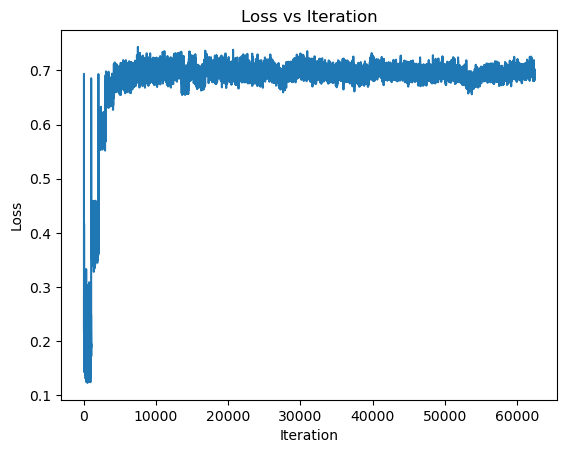

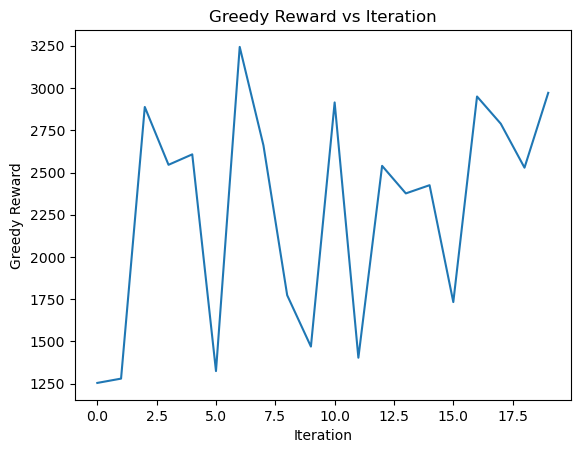

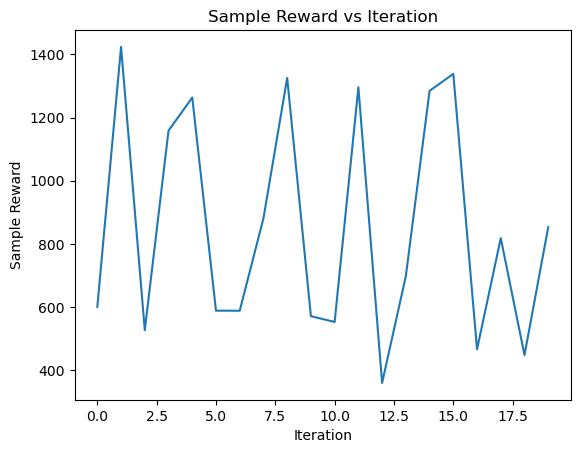

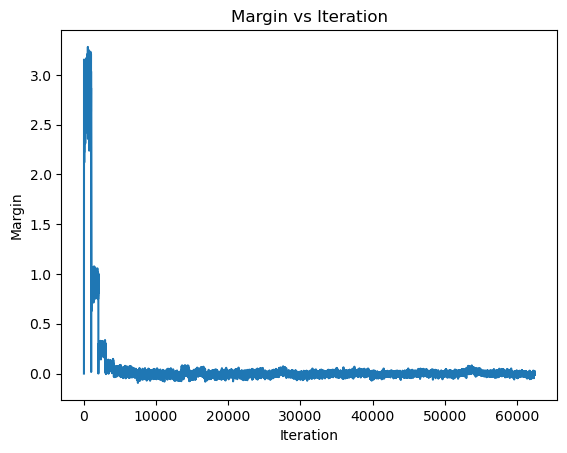

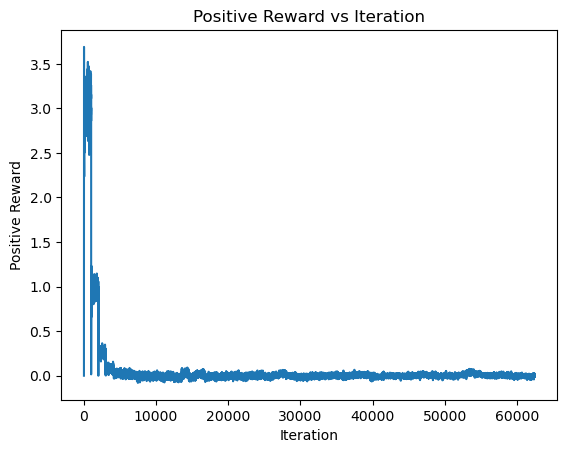

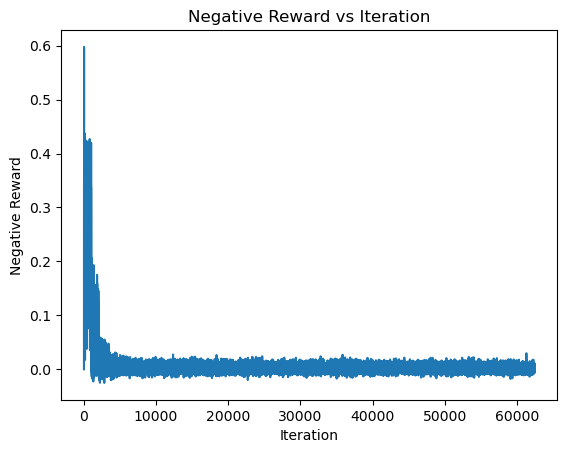

In [22]:
# save all png to /mnt/nfs/work/albertliu/RL/CartPole-v1/DPO

# draw the loss graph
import matplotlib.pyplot as plt
plt.plot(loss_graph)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss vs Iteration")
plt.savefig("./loss.png")

plt.show()



# draw the reward graph
plt.plot(greedy_rewards)
plt.xlabel("Iteration")
plt.ylabel("Greedy Reward")
plt.title("Greedy Reward vs Iteration")
plt.savefig("./greedy_reward.png")
plt.show()

# draw the reward graph
plt.plot(sample_rewards)
plt.xlabel("Iteration")
plt.ylabel("Sample Reward")
plt.title("Sample Reward vs Iteration")
plt.savefig("./sample_reward.png")
plt.show()


# drqw the margin graph
plt.plot(margin_graph)
plt.xlabel("Iteration")
plt.ylabel("Margin")
plt.title("Margin vs Iteration")
plt.savefig("./margin.png")
plt.show()

# draw the positive reward graph
plt.plot(positive_reward_graph)
plt.xlabel("Iteration")
plt.ylabel("Positive Reward")
plt.title("Positive Reward vs Iteration")
plt.savefig("./positive_reward.png")
plt.show()

# draw the negative reward graph
plt.plot(negative_reward_graph)
plt.xlabel("Iteration")
plt.ylabel("Negative Reward")
plt.title("Negative Reward vs Iteration")

plt.savefig("./negative_reward.png")
plt.show()


In [23]:
# from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv
# from stable_baselines3.common.vec_env import VecEnv
# import gymnasium as gym
# from imitation.policies.serialize import load_policy
# from imitation.util.util import make_vec_env
# import numpy as np
# import torch
# import os

# # 创建环境
# env = make_vec_env(
#     "seals:seals/Walker2d-v1",
#     rng=np.random.default_rng(),
#     n_envs=1,
#     env_make_kwargs={"render_mode": "rgb_array"},
# )

# # 使用 VecVideoRecorder 包装环境以启用视频记录，指定视频保存的路径
# video_folder = './videos'
# video_length = 200  # 设置视频长度
# env = VecVideoRecorder(env, video_folder,
#                        record_video_trigger=lambda step: step == 0, video_length=video_length,
#                        name_prefix="Walker2d-video")

# # 创建模型，这里以从 Hugging Face 加载预训练的 PPO 模型为例
# model = load_policy(
#     "ppo-huggingface",
#     organization="HumanCompatibleAI",
#     env_name="seals/Walker2d-v1",
#     venv=env,
# )

# # 训练模型
# # 注意: 此处假定模型已经预训练，无需再次训练

# # 测试模型，生成视频
# obs = env.reset()
# done = False
# while not done:
#     action, _states = model.predict(obs, deterministic=True)
#     obs, rewards, dones, info = env.step(action)
#     done = dones.any()

# env.close()

# # 如果需要手动保存视频（有时候视频不会在关闭时自动保存）
# env.record_video_trigger(video_length)
